# Cеминар 6. Seq2seq и Механизм Внимания

В этом ноутбуке мы погрузимся в архитектуру **Кодировщик-Декодировщик (Encoder-Decoder)** на примере задачи машинного перевода с русского на английский $Ru \to En$.

Сегодня мы реализуем три ключевые модели:
1. **Baseline Seq2seq**. Классическая модель с фиксированным вектором контекста ("бутылочное горлышко").

2. **Seq2seq + Additive Attention (Bahdanau)**. Модель с механизмом внимания, использующая дополнительный MLP для вычисления весов.

3. **Seq2seq + Scaled Dot-Product Attention**. Модель, использующая внимание в стиле Transformer, на основе скалярного произведения.

Мы сравним качество (BLEU) и визуализируем карты внимания, чтобы понять, как каждая модель работает с зависимостями между токенами.

**Архитектуры кодировщик-декодировщик** предназначены для преобразования что угодно во что угодно, включая:

* машинный перевод и диалоговые системы;
* описание изображений и image2latex (CNN-энкодер + RNN-декодер);
* генерация изображений по тексту (RNN-энкодер + CNN-декодер);
* grapheme2phoneme - преобразование слов в транскрипции.


**План занятия**

Мы будем переводить **описания отелей/хостелов** с русского на английский. Это хороший учебный компромисс, ведь задача похожа на настоящий машинный перевод, данные достаточно небольшие, чтобы можно было обучать модель без недель ожидания (но GPU всё равно приятно ускоряет жизнь).

- Подготовка окружения (зависимости, загрузка данных)

- Токенизация и BPE

- Словари и разбиение train/dev

- Реализация baseline seq2seq

- Loss (masked cross entropy) и BLEU

- Обучение baseline

- Additive attention + attentive seq2seq

- Визуализация attention

- Dot-product attention + attentive seq2seq

- Сравнение моделей + выводы

**Об источнике материалов**

Настоящая семинарская тетрадь основана на материалах открытого курса YSDA Natural Language Processing (Yandex School of Data Analysis, автор курса - Elena Voita), размещённого в репозитории https://github.com/yandexdataschool/nlp_course (лицензия MIT). При подготовке были частично использован и адаптирован следующий ноутбук:

- `week03_attention/new_practice_and_homework.ipynb`

Все авторские права на исходные материалы принадлежат их авторам и Яндекс Школе анализа данных. Изменения, дополнения и комментарии в данной тетрадке сделаны исключительно в учебных целях.

### Установка зависимостей и загрузка данных

In [ ]:
!pip -q install "torch>=1.3.0" nltk subword-nmt bokeh tqdm

!wget -q "https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1" -O data.txt
!wget -q "https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py" -O vocab.py

print("OK: packages installed, files downloaded.")

OK: packages installed, files downloaded.


### Токенизация + Byte Pair Encoding

Сначала нам нужно превратить исходные строки в формат, с которым нейросети удобно жить. В `data.txt` каждая строка - это пара **EN ↔ RU**, разделённая табом (`\t`). Мы будем решать задачу **RU → EN**, поэтому дальше русский станет *входом* (inp), а английский - *целевым переводом* (out).

Токенизация здесь максимально простая: `WordPunctTokenizer` режет текст на слова и знаки пунктуации, мы приводим всё к нижнему регистру и склеиваем токены обратно через пробел. Это не *идеальная лингвистика*, но для учебного seq2seq - ровно то, что надо: быстро, прозрачно, воспроизводимо.

Дальше - важный трюк с редкими словами. Если переводить на уровне слов, словарь раздувается (имена, адреса, необычные написания), а модель начинает тонуть в `UNK`. Если уйти в символы - последовательности станут слишком длинными. Поэтому используем **BPE**: алгоритм стартует с почти-символьного уровня и делает фиксированное число слияний самых частотных пар. В результате частые слова превращаются в один токен, а редкие - раскладываются на подслова. Это резко уменьшает словарь и повышает устойчивость к незнакомым словам.

В этом коде мы:

1. разделяем данные на `train.en` и `train.ru`,
2. учим BPE-правила отдельно для каждого языка (параметр `num_symbols=8000` задаёт размер пространства слияний),
3. применяем BPE и получаем `train.bpe.en` / `train.bpe.ru`.

Обрати внимание: BPE обычно помечает незаконченный подслово-токен маркером вроде `@@` - позже при оценке BLEU мы это аккуратно уберём.


In [ ]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

tokenizer = WordPunctTokenizer()

def tokenize(text: str) -> str:
    """Простая токенизация: разбиваем на токены + lower + склеиваем обратно."""
    return " ".join(tokenizer.tokenize(text.lower()))

# разделим исходные пары на два файла: train.en и train.ru
# это нужно для обучения BPE отдельно для каждого языка
with open("train.en", "w", encoding="utf-8") as f_src, open("train.ru", "w", encoding="utf-8") as f_dst:
    for line in open("data.txt", encoding="utf-8"):
        src_line, dst_line = line.strip().split("\t")
        f_src.write(tokenize(src_line) + "\n")
        f_dst.write(tokenize(dst_line) + "\n")

print("Tokenized files created: train.en, train.ru")

# обучим BPE и применим
bpe = {}
num_symbols = 8000  # размер словаря слияний BPE

for lang in ["en", "ru"]:
    # правила BPE
    with open(f"bpe_rules.{lang}", "w", encoding="utf-8") as rules_out:
        learn_bpe(open(f"train.{lang}", encoding="utf-8"), rules_out, num_symbols=num_symbols)

    # загружаем обученные правила
    bpe[lang] = BPE(open(f"bpe_rules.{lang}", encoding="utf-8"))

    # применим BPE к данным
    with open(f"train.bpe.{lang}", "w", encoding="utf-8") as f_out:
        for line in open(f"train.{lang}", encoding="utf-8"):
            # process_line разбивает слова на суб-слова
            f_out.write(bpe[lang].process_line(line.strip()) + "\n")

print("BPE applied: train.bpe.en, train.bpe.ru")

Tokenized files created: train.en, train.ru


100%|██████████| 8000/8000 [00:08<00:00, 917.03it/s] 


BPE applied: train.bpe.en, train.bpe.ru


### Словари и train/dev split

Теперь строки надо превратить в числа. Для этого мы создадим два словаря: `inp_voc` для русского и `out_voc` для английского. Словарь умеет:

* кодировать строки в матрицу токен-id (`to_matrix`) - это то, что пойдёт в модель,
* декодировать матрицу обратно в строки (`to_lines`) - это то, что мы будем читать глазами после инференса.

Мы также делаем разбиение на `train` и `dev`: обучаемся на `train`, а качество (BLEU) считаем на `dev`. Размер dev здесь фиксирован (`test_size=3000`) - удобно, потому что оценка не будет плавать от запуска к запуску.

После этого мы смотрим на несколько примеров пар RU/EN, чтобы убедиться, что всё сошлось (языки не перепутаны, BPE применился, строки не пустые), и строим гистограммы длин. Это маленький шаг, который экономит много времени: по распределениям сразу видно, какой `max_len` имеет смысл ставить при генерации и насколько длинные зависимости вообще есть в данных.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

data_inp = np.array(open("./train.bpe.ru", encoding="utf-8").read().split("\n"))
data_out = np.array(open("./train.bpe.en", encoding="utf-8").read().split("\n"))

# уберём возможную пустую строку в конце
data_inp = data_inp[data_inp != ""]
data_out = data_out[data_out != ""]

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp, data_out, test_size=3000, random_state=42
)

for i in range(3):
    print("RU:", train_inp[i])
    print("EN:", train_out[i])
    print()

from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

print("Input vocab size:", len(inp_voc))
print("Output vocab size:", len(out_voc))

RU: на территории обустроена бесплатная частная парковка .
EN: free private parking is available on site .

RU: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
EN: guests can find many bars and restaurants within a 5 - minute walk .

RU: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
EN: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .

Input vocab size: 8049
Output vocab size: 7800


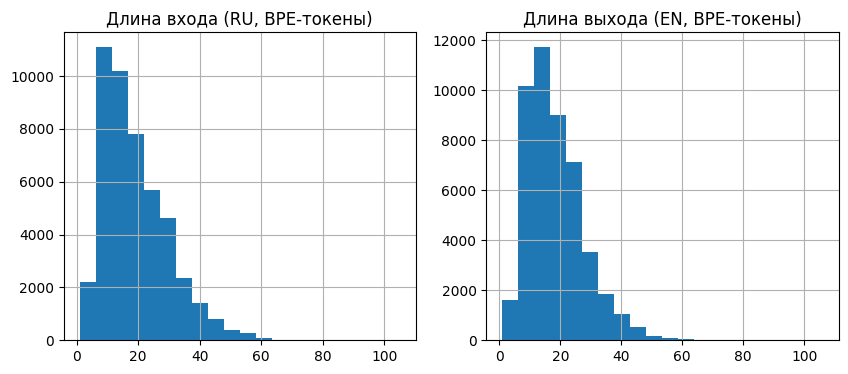

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Длина входа (RU, BPE-токены)")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20)
plt.grid()

plt.subplot(1, 2, 2)
plt.title("Длина выхода (EN, BPE-токены)")
plt.hist(list(map(len, map(str.split, train_out))), bins=20)
plt.grid()

plt.show()

### Устройство, воспроизводимость

Дальше мы выбираем устройство: `cuda`, если доступна, иначе CPU. Seq2seq на RNN может быть заметно медленнее на CPU, поэтому на семинаре GPU - большой плюс, но не обязательность (просто уменьшаем число шагов обучения).

Функция `set_seed` фиксирует источники случайности (python/numpy/torch). Это не делает обучение полностью детерминированным во всех режимах, но заметно повышает воспроизводимость: графики и BLEU будут похожи между запусками, а не каждый раз новая история.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed: int = 42):
    """Фиксируем случайность для воспроизводимости на семинаре."""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Device: cuda


### Маска до первого EOS: зачем так сложно?

В этом ноутбуке EOS играет двойную роль: это и конец предложения, и фактически паддинг, потому что после EOS мы обычно добиваем последовательность EOS-ами до общей длины батча.

Поэтому нам нужна маска **до первого EOS включительно**: всё, что после - это уже не содержательная часть последовательности.

Функция `first_eos_mask` делает ровно это. Она важна в двух местах:

* чтобы корректно взять последнее осмысленное состояние энкодера (а не состояние на паддинге),
* чтобы правильно считать `loss` только по настоящим токенам, а не по хвосту паддинга.

Если игнорировать этот момент, модель будет учиться предсказывать паддинг, метрики станут странными, а обучение - менее стабильным.

In [ ]:
def first_eos_mask(tokens: torch.Tensor, eos_ix: int) -> torch.Tensor:
    """
    Маска, которая равна 1 до ПЕРВОГО EOS ВКЛЮЧИТЕЛЬНО и 0 после него.
    Это удобно, когда EOS также используется как PAD (повторяется много раз).

    tokens: [batch, time]
    return: [batch, time] float32
    """
    is_eos = (tokens == eos_ix).to(torch.int64) # 1 там, где eos
    eos_count = torch.cumsum(is_eos, dim=1) # сколько eos встретили к текущей позиции
    mask = (eos_count <= 1).to(torch.float32) # до 1-го eos включительно
    return mask

### Базовая модель: encoder–decoder без attention

Начнём с baseline - простой и честной модели, чтобы было с чем сравнивать улучшения.

Идея такая:

* **Encoder (GRU)** читает входную последовательность RU и выдаёт последовательность скрытых состояний `enc_seq`.
* Мы берём **последнее валидное** состояние энкодера (по маске до EOS) и превращаем его линейным слоем в стартовое состояние декодера `dec_state0`.
* **Decoder (GRUCell)** генерирует перевод пошагово. На каждом шаге он получает embedding предыдущего выходного токена и обновляет скрытое состояние, а затем выдаёт логиты по словарю.

Есть два режима работы:

* `decode` (teacher forcing): на вход декодеру подаются **истинные токены** - так мы обучаемся.
* `decode_inference` (greedy): на вход декодеру подаются **собственные предсказания** - так мы переводим.

Обрати внимание на небольшой, но полезный инженерный момент: `translate_lines` везде возвращает три значения `(translations, states, attention_probs)`. Для baseline `attention_probs=None`. Это сделано специально, чтобы дальше (в attention-моделях) не переписывать весь код оценки/визуализации.

In [ ]:
class BasicModel(nn.Module):
    """
    Базовая encoder-decoder модель без attention.
    Важно: интерфейс translate_lines() возвращает 3 значения, как и attentive модель:
      translations, states, attention_probs
    где attention_probs=None (потому что attention нет).
    """
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)

        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        # Переводим энкодерное состояние в стартовое состояние декодера
        self.dec_start = nn.Linear(hid_size, hid_size)

        # GRUCell: один шаг декодера (берём embedding предыдущего токена)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """Прогон в режиме teacher forcing: на вход декодеру подаются истинные токены."""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def encode(self, inp):
        """
        inp: [batch, time] int64
        return: list состояния (в базовой модели это [dec_state0])
        """
        inp_emb = self.emb_inp(inp)                      # [B, T, E]
        enc_seq, _ = self.enc0(inp_emb)                  # [B, T, H]

        # Маска до первого EOS включительно => получаем длины (индекс последнего валидного токена)
        inp_mask = first_eos_mask(inp, self.inp_voc.eos_ix)        # [B, T]
        lengths = (inp_mask.sum(dim=1).long() - 1).clamp_min(0)    # [B]
        last_state = enc_seq[torch.arange(enc_seq.size(0), device=inp.device), lengths]  # [B, H]

        dec_state0 = self.dec_start(last_state)          # [B, H]
        return [dec_state0]

    def decode_step(self, prev_state, prev_tokens):
        """
        prev_state: [prev_dec_state]
        prev_tokens: [B] int64 - предыдущий токен выхода
        return: (new_state_list, logits)
        """
        (prev_h,) = prev_state

        prev_emb = self.emb_out(prev_tokens)             # [B, E]
        new_h = self.dec0(prev_emb, prev_h)              # [B, H]
        logits = self.logits(new_h)                      # [B, V]

        return [new_h], logits

    def decode(self, initial_state, out_tokens):
        """
        Teacher forcing декодирование:
        out_tokens: [B, T_out] - истинная последовательность (включает BOS и EOS)
        Возвращаем logits для каждого шага (включая "нулевой" шаг, где всегда BOS).
        """
        B, T = out_tokens.shape
        state = initial_state

        # На "нулевом" шаге модель "предсказывает" BOS с вероятностью 1 (как фиктивный logits)
        onehot_bos = F.one_hot(
            torch.full([B], self.out_voc.bos_ix, dtype=torch.int64, device=out_tokens.device),
            num_classes=len(self.out_voc)
        ).to(torch.float32)
        first_logits = torch.log(onehot_bos + 1e-9)      # [B, V]

        logits_seq = [first_logits]
        for t in range(T - 1):
            state, logits = self.decode_step(state, out_tokens[:, t])
            logits_seq.append(logits)

        return torch.stack(logits_seq, dim=1)            # [B, T, V]

    def decode_inference(self, initial_state, max_len=100):
        """
        Greedy decoding:
        генерируем max_len токенов (не считая стартового BOS), attention_probs отсутствуют.
        """
        B = initial_state[0].size(0)
        state = initial_state

        outputs = [torch.full([B], self.out_voc.bos_ix, dtype=torch.int64, device=initial_state[0].device)]
        states = [initial_state]

        for _ in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            next_tok = logits.argmax(dim=-1)
            outputs.append(next_tok)
            states.append(state)

        out_ids = torch.stack(outputs, dim=1)            # [B, 1+max_len]
        return out_ids, states, None

    def translate_lines(self, inp_lines, max_len=100):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states, attn_probs = self.decode_inference(initial_state, max_len=max_len)
        translations = self.out_voc.to_lines(out_ids.cpu().numpy())
        return translations, states, attn_probs

### Функция потерь: cross-entropy по токенам до EOS

Обучаемся стандартной токен-уровневой cross-entropy: на каждом шаге хотим максимизировать вероятность правильного следующего токена. Но считаем loss **только там, где маска = 1**, то есть до первого EOS включительно.

Почему *включительно*? Потому что EOS - часть задачи: модель должна уметь **останавливать** генерацию. Если не учитывать EOS в loss, модель часто учится переводить вечно, и инференс превращается в поток бессмысленных токенов.

Формально оптимизируем средний **negative log-likelihood**:

$$
L = \frac{1}{|D|} \sum_{(X,Y)\in D}\sum_{t} -\log p(y_t \mid y_{<t}, X, \theta)
$$


Технически реализовано так: мы разворачиваем `[B, T, V]` в `[B*T, V]`, берём `F.cross_entropy(..., reduction="none")`, умножаем на `mask_flat` и нормируем на сумму маски. Это простой и надёжный способ избежать ошибок со сдвигами и паддингом.

> Ключевые детали, на которых чаще всего ломаются реализации:
>
>* маска паддинга: в батче последовательности разной длины -> часть токенов - это пустота, их нельзя учитывать в loss;
>* EOS: мы учитываем loss до первого EOS включительно, но не считаем дальнейшие EOS, которые появляются из-за паддинга;
> * нормировка: делим сумму потерь на количество токенов под маской, чтобы loss был сопоставим между батчами.

In [ ]:
def compute_loss(model, inp, out):
    """
    Средняя cross-entropy по всем токенам до первого EOS включительно (по маске).
    Важно: out уже содержит BOS...EOS...EOS... (EOS дальше = padding).
    """
    # mask: 1 до первого EOS включительно
    mask = first_eos_mask(out, model.out_voc.eos_ix) # [B, T_out]

    logits_seq = model(inp, out) # [B, T_out, V]
    B, T, V = logits_seq.shape

    logits_flat = logits_seq.reshape(-1, V) # [B*T, V]
    out_flat = out.reshape(-1) # [B*T]
    mask_flat = mask.reshape(-1) # [B*T]

    per_token_loss = F.cross_entropy(logits_flat, out_flat, reduction="none") # [B*T]
    loss = (per_token_loss * mask_flat).sum() / mask.sum().clamp_min(1.0)
    return loss

### BLEU: как мы измеряем качество перевода

Для машинного перевода мы будем считать **BLEU** на dev. Важно помнить две вещи:

1. У нас BPE, поэтому перед подсчётом BLEU мы склеиваем подслова обратно (убираем `@@ `).
2. BLEU здесь - **корпусная** метрика: она становится осмысленной на наборе предложений, а не на одном примере.

Внутри `compute_bleu` мы переводим входные строки через `model.translate_lines`, приводим строки к "без-BPE" виду и считаем `corpus_bleu`. Это не самый продвинутый вариант (для отчётов чаще берут `sacrebleu`), но для учебного ноутбука - отлично: просто и прозрачно.


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def compute_bleu(model, inp_lines, out_lines, bpe_sep="@@ ", max_len=100):
    """
    Корпусный BLEU (nltk). Для отчётов лучше sacrebleu, но для семинара OK.
    model.translate_lines всегда возвращает (translations, states, attention_probs).
    """
    model.eval()
    with torch.no_grad():
        translations, _, _ = model.translate_lines(inp_lines, max_len=max_len)

    translations = [s.replace(bpe_sep, "") for s in translations]
    actual = [s.replace(bpe_sep, "") for s in out_lines]

    bleu = corpus_bleu(
        [[ref.split()] for ref in actual],
        [hyp.split() for hyp in translations],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
    ) * 100

    model.train()
    return bleu

### One function to train them all

`train_loop` - это общий цикл обучения и для baseline, и для attention-моделей. Мы случайно выбираем батч индексов, переводим строки в матрицы токенов через словари, считаем loss, делаем шаг оптимизатора Adam.

Раз в `eval_every` шагов мы считаем BLEU на dev и рисуем два графика:

* `train_loss` (должен в среднем падать),
* `dev_bleu` (должен в среднем расти, хотя может колебаться).

На семинаре удобно держать `n_steps` в районе 2000–5000: это даёт динамику без долгого ожидания. Если запускаете на CPU - смело уменьшайте `batch_size`, `n_steps` и/или делайте оценку реже.


In [ ]:
from IPython.display import clear_output
from tqdm import trange

def train_loop(model, train_inp, train_out, dev_inp, dev_out,
               n_steps=3000, batch_size=64, lr=1e-3,
               eval_every=200, max_len_bleu=60):
    """
    Универсальный цикл обучения для BasicModel и AttentiveModel.
    На семинаре можно поставить n_steps=2000..5000, чтобы не ждать долго.
    """
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "dev_bleu": []}

    for step in trange(1, n_steps + 1):
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

        loss = compute_loss(model, batch_inp, batch_out)
        opt.zero_grad()
        loss.backward()
        opt.step()

        history["train_loss"].append((step, float(loss.item())))

        if step % eval_every == 0:
            bleu = compute_bleu(model, dev_inp, dev_out, max_len=max_len_bleu)
            history["dev_bleu"].append((step, float(bleu)))

            clear_output(True)
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.title("train_loss")
            xs, ys = zip(*history["train_loss"])
            plt.plot(xs, ys)
            plt.grid()

            plt.subplot(1, 2, 2)
            plt.title("dev_bleu")
            if len(history["dev_bleu"]) > 0:
                xs, ys = zip(*history["dev_bleu"])
                plt.plot(xs, ys)
            plt.grid()

            plt.show()
            print(f"Step={step} | loss={np.mean([x[1] for x in history['train_loss'][-10:]]):.3f} | BLEU={bleu:.2f}")

    return model, history

### Baseline модель, обучаем и смотрим BLEU

В этом блоке мы создаём `BasicModel`, прогоняем `train_loop`, а потом считаем финальный BLEU на небольшом подмножестве dev (чтобы быстро). Это наша отправная точка: дальше будем улучшать архитектуру, и нам нужно видеть, что улучшение - это действительно улучшение, а не кажется стало лучше.


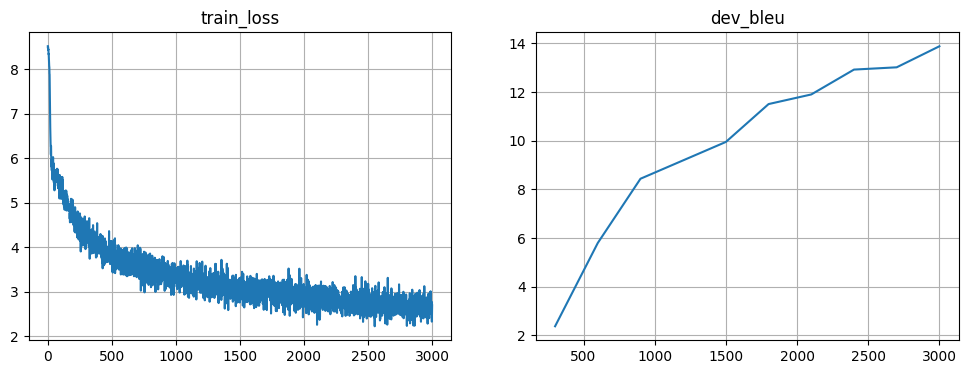

100%|██████████| 3000/3000 [02:00<00:00, 24.85it/s]

Step=3000 | loss=2.580 | BLEU=13.89
Final BLEU (baseline): 13.963943067228888


In [ ]:
baseline = BasicModel(inp_voc, out_voc, emb_size=64, hid_size=128)

# Меньше шагов (быстро), для по-взрослому можно 20000-30000
baseline, hist_base = train_loop(
    baseline, train_inp, train_out, dev_inp, dev_out,
    n_steps=3000, batch_size=64, eval_every=300, lr=1e-3
)

print("Final BLEU (baseline):", compute_bleu(baseline, dev_inp[:1000], dev_out[:1000], max_len=60))

###  Additive attention

Теперь добавим внимание (**Bahdanau/additive**). Интуиция: когда декодер генерирует очередной токен, ему полезно **посмотреть на разные части входа**, а не опираться только на один стартовый вектор.

1. считаем для каждого encoder-состояния логит важности через небольшую сеть:
  $$
  a_t = W_{\text{out}}\big(\tanh(W_e h^e_t + W_d h^d)\big)
  $$
2. превращаем логиты в вероятности softmax'ом:
  $$
  p_t = \frac{e^{a_t}}{\sum_\tau e^{a_\tau}}
  $$
3. получаем контекст как взвешенную сумму encoder-состояний:
  $$
  attn = \sum_t p_t \cdot h^e_t
  $$

Механика простая:

* на каждом шаге мы сравниваем текущее состояние декодера с каждым состоянием энкодера и получаем **logits важности** по времени,
* применяем маску, чтобы не смотреть в паддинг,
* softmax превращает logits в вероятности,
* получаем `context` как взвешенную сумму состояний энкодера.

Приятный бонус additive attention - она хорошо визуализируется: веса внимания часто дают понятную диагональную структуру что переводим прямо сейчас.


In [ ]:
class AdditiveAttention(nn.Module):
    """
    Additive attention (Bahdanau):
    logits_t = W_out( tanh(W_e h^e_t + W_d h^d) )
    """
    def __init__(self, enc_size, dec_size, hid_size):
        super().__init__()
        self.linear_e = nn.Linear(enc_size, hid_size)
        self.linear_d = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)

    def forward(self, enc_seq, dec_state, enc_mask):
        """
        enc_seq:  [B, T_inp, H]
        dec_state:[B, H]
        enc_mask: [B, T_inp] (1 до первого EOS включительно, 0 после)

        return:
          context: [B, H]  (взвешенная сумма по времени)
          probs:   [B, T_inp] (веса attention)
        """
        # приводим к общему hid-размеру
        e = self.linear_e(enc_seq) # [B, T, A]
        d = self.linear_d(dec_state).unsqueeze(1) # [B, 1, A]

        logits = self.linear_out(torch.tanh(e + d)).squeeze(-1) # [B, T]

        # маскирование: где enc_mask==0, делаем logits очень маленькими
        logits = torch.where(enc_mask > 0, logits, torch.full_like(logits, -1e9))

        probs = F.softmax(logits, dim=1) # [B, T]
        context = torch.sum(probs.unsqueeze(-1) * enc_seq, dim=1) # [B, H]
        return context, probs

### AttentiveModel: seq2seq + additive attention

Здесь мы встраиваем **attention в decoder**.

![img](https://i.imgur.com/6fKHlHb.png)

_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

Ключевая идея реализации - **состояние модели**. Мы храним не только `dec_state`, но и `enc_seq` + `enc_mask` прямо внутри `state` списка. Тогда `decode_step` на каждом шаге имеет доступ ко всему нужному:

* берём embedding предыдущего токена,
* считаем `context, probs = attention(enc_seq, dec_state, enc_mask)`,
* склеиваем `[prev_emb, context]` и подаём в `GRUCell`,
* сохраняем `probs`, чтобы потом визуализировать карты внимания.

В `decode_inference` мы дополнительно собираем attention-веса по шагам в тензор формы `[B, T_gen, T_inp]`. Это именно тот формат, который удобно подавать на heatmap.


In [ ]:
class AttentiveModel(nn.Module):
    """
    Encoder-decoder с additive attention.
    Интерфейс совместим с BasicModel:
      translate_lines -> (translations, states, attention_probs)
    attention_probs имеет форму [batch, T_gen, T_inp].
    """
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)

        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.attn = AdditiveAttention(enc_size=hid_size, dec_size=hid_size, hid_size=attn_size)

        self.dec_start = nn.Linear(hid_size, hid_size)

        # в декодер подаём [emb(prev_token), context] => размер emb_size + hid_size
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def encode(self, inp):
        inp_emb = self.emb_inp(inp) # [B, T, E]
        enc_seq, _ = self.enc0(inp_emb) # [B, T, H]

        enc_mask = first_eos_mask(inp, self.inp_voc.eos_ix) # [B, T]
        lengths = (enc_mask.sum(dim=1).long() - 1).clamp_min(0) # [B]
        last_state = enc_seq[torch.arange(enc_seq.size(0), device=inp.device), lengths] # [B, H]

        dec_state0 = self.dec_start(last_state) # [B, H]

        # cостояние будем хранить как список:
        # [dec_state, enc_seq, enc_mask]
        return [dec_state0, enc_seq, enc_mask]

    def decode_step(self, prev_state, prev_tokens):
        dec_state, enc_seq, enc_mask = prev_state

        prev_emb = self.emb_out(prev_tokens) # [B, E]

        # attention по enc_seq, используя текущее (предыдущее) состояние декодера как запрос
        context, probs = self.attn(enc_seq, dec_state, enc_mask) # context [B,H], probs [B,T_inp]

        dec_input = torch.cat([prev_emb, context], dim=-1) # [B, E+H]
        new_dec_state = self.dec0(dec_input, dec_state) # [B, H]
        logits = self.logits(new_dec_state) # [B, V]

        new_state = [new_dec_state, enc_seq, enc_mask]
        return new_state, logits, probs

    def decode(self, initial_state, out_tokens):
        B, T = out_tokens.shape
        state = initial_state

        onehot_bos = F.one_hot(
            torch.full([B], self.out_voc.bos_ix, dtype=torch.int64, device=out_tokens.device),
            num_classes=len(self.out_voc)
        ).to(torch.float32)
        first_logits = torch.log(onehot_bos + 1e-9)

        logits_seq = [first_logits]
        for t in range(T - 1):
            state, logits, _ = self.decode_step(state, out_tokens[:, t])
            logits_seq.append(logits)

        return torch.stack(logits_seq, dim=1)

    def decode_inference(self, initial_state, max_len=100):
        B = initial_state[0].size(0)
        state = initial_state

        outputs = [torch.full([B], self.out_voc.bos_ix, dtype=torch.int64, device=initial_state[0].device)]
        states = [initial_state]

        # собираем attention probs по шагам: список элементов [B, T_inp]
        attn_steps = []

        for _ in range(max_len):
            state, logits, probs = self.decode_step(state, outputs[-1])
            next_tok = logits.argmax(dim=-1)

            outputs.append(next_tok)
            states.append(state)
            attn_steps.append(probs.detach()) # [B, T_inp]

        out_ids = torch.stack(outputs, dim=1) # [B, 1+max_len]

        # преобразуем в [B, T_gen, T_inp]
        # T_gen = max_len (кол-во шагов генерации, без BOS)
        attention_probs = torch.stack(attn_steps, dim=1).cpu().numpy() if len(attn_steps) > 0 else None

        return out_ids, states, attention_probs

    def translate_lines(self, inp_lines, max_len=100):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states, attention_probs = self.decode_inference(initial_state, max_len=max_len)
        translations = self.out_voc.to_lines(out_ids.cpu().numpy())
        return translations, states, attention_probs

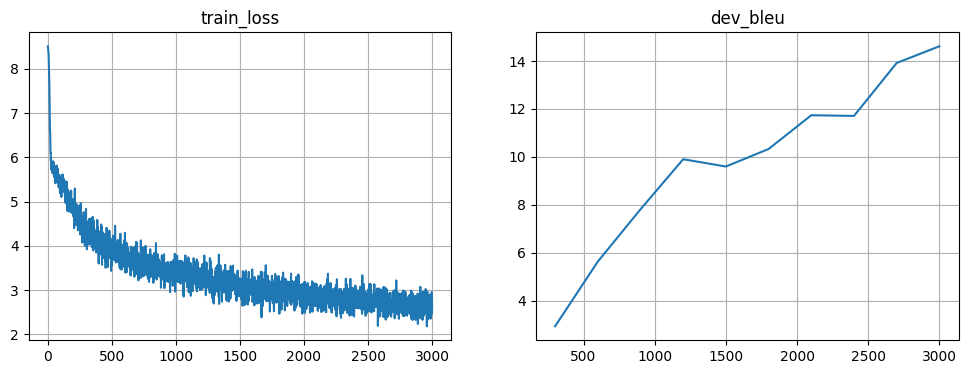

100%|██████████| 3000/3000 [04:51<00:00, 10.28it/s]

Step=3000 | loss=2.720 | BLEU=14.61


Final BLEU (attn): 15.030050010228058


In [ ]:
attn_model = AttentiveModel(inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128)

attn_model, hist_attn = train_loop(
    attn_model, train_inp, train_out, dev_inp, dev_out,
    n_steps=3000, batch_size=64, eval_every=300, lr=1e-3
)

print("Final BLEU (attn):", compute_bleu(attn_model, dev_inp[:1000], dev_out[:1000], max_len=60))

###  Визуализация attention-карт ([Bokeh](https://docs.bokeh.org/en/latest/index.html))

Функция `draw_attention` строит heatmap: по оси X - токены входа (source), по оси Y - токены перевода (translation). Мы обрезаем матрицу внимания по реальным длинам токенов, чтобы картинка не была забита паддингом.

Если модель обучилась хоть немного, на картах часто появляется структура: локальные соответствия, перескоки на важные слова, а иногда даже аккуратная диагональ. Если же всё выглядит как шум - это сигнал, что модель ещё не доучилась или attention фактически не используется (такое тоже бывает).


In [ ]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
output_notebook()

def draw_attention(inp_line, translation, probs_2d):
    """
    inp_line: исходная строка
    translation: предсказанный перевод (строка)
    probs_2d: [T_gen, T_inp] - attention веса по шагам
    """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)

    # обрежем по реальным длинам (чтобы heatmap была аккуратной)
    probs_2d = probs_2d[:len(trans_tokens), :len(inp_tokens)]

    fig = pl.figure(
        x_range=(0, len(inp_tokens)),
        y_range=(0, len(trans_tokens)),
        x_axis_type=None, y_axis_type=None, tools=[]
    )
    fig.image([probs_2d[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label="source tokens"), "above")
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label="translation tokens"), "left")
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)

# возьмём несколько примеров из dev
sample_inp = dev_inp[::500][:5]

translations, _, attention_probs = attn_model.translate_lines(sample_inp, max_len=60)

for i in range(len(sample_inp)):
    print("RU:", sample_inp[i])
    print("EN:", translations[i])
    print()

    # attention_probs: [batch, T_gen, T_inp]
    draw_attention(sample_inp[i], translations[i], attention_probs[i])

RU: в распоряжении гостей общая кухня и общая гостиная .
EN: there is a shared kitchen and a shared kitchen at the property .



RU: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
EN: other facilities offered at the property include meeting facilities , and free parking .



RU: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
EN: the nearest airport is 43 km from the property .



RU: апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
EN: located in the centre of the beach , this apartment features a terrace , a terrace and a terrace . the property is a 5 - minute walk from the beach .



RU: апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
EN: the property is located in the centre of the town of the city of the city of the city of the city of the city of the city of the city of the city centre .



### Scaled dot-product attention: ближе к Transformer-логике

Дальше мы реализуем dot-product attention со скейлингом. Это родственник attention в трансформерах: вместо небольшой MLP (как в additive) мы сравниваем query и keys через скалярное произведение.

Здесь появляются проекции **Q/K/V**:

* `q = W_q(dec_state)`
* `k = W_k(enc_seq)`
* `v = W_v(enc_seq)`

Затем считаем logits как `q·k_t` и делим на `sqrt(dk)` (это важно для стабильности softmax при больших размерностях). Маска применяется так же, как и раньше: всё, что после EOS, выбрасываем через очень маленькие logits.

В учебном плане это полезно по двум причинам:
(1) вы видите, как устроена трансформерная attention в простом RNN-контексте;
(2) можно сравнить, как меняются BLEU и карты внимания при прочих равных.


In [ ]:
import math

class DotProductAttention(nn.Module):
    """
    Scaled dot-product attention с проекциями:
      q = Wq * dec_state
      k = Wk * enc_state_t
      v = Wv * enc_state_t

    logits_t = (q · k_t) / sqrt(dk)
    probs = softmax(masked_logits)
    context = sum_t probs_t * v_t

    Важно: мы выберем размер query/key пространства dk=attn_size,
    а value-пространство сделаем размером enc_size (т.е. H), чтобы
    context удобно подавать в декодер.
    """
    def __init__(self, enc_size: int, dec_size: int, attn_size: int):
        super().__init__()
        self.enc_size = enc_size
        self.dec_size = dec_size
        self.attn_size = attn_size

        # проекции: q,k в пространство размера dk=attn_size
        self.W_q = nn.Linear(dec_size, attn_size, bias=False)
        self.W_k = nn.Linear(enc_size, attn_size, bias=False)

        # values оставим размера enc_size, чтобы context был [B, enc_size]
        self.W_v = nn.Linear(enc_size, enc_size, bias=False)

    def forward(self, enc_seq, dec_state, enc_mask):
        """
        enc_seq:  [B, T_inp, H]
        dec_state:[B, H]
        enc_mask: [B, T_inp] (1 до первого EOS включительно, 0 после)

        return:
          context: [B, H]
          probs:   [B, T_inp]
        """
        # считаем Q, K, V
        q = self.W_q(dec_state) # [B, dk]
        k = self.W_k(enc_seq) # [B, T, dk]
        v = self.W_v(enc_seq) # [B, T, H]

        # logits = (q · k_t) / sqrt(dk)
        # gриводим q к [B, 1, dk] для broadcast
        q_exp = q.unsqueeze(1) # [B, 1, dk]
        logits = (k * q_exp).sum(dim=-1) # [B, T]
        logits = logits / math.sqrt(self.attn_size)

        # маска: там где enc_mask==0 делаем -1e9
        logits = torch.where(enc_mask > 0, logits, torch.full_like(logits, -1e9))

        # softmax -> probs
        probs = F.softmax(logits, dim=1) # [B, T]

        # context = sum_t probs_t * v_t
        context = torch.sum(probs.unsqueeze(-1) * v, dim=1) # [B, H]
        return context, probs

### AttentiveModelDot - та же модель, другой attention

Эта модель полностью совместима с уже написанными `compute_loss`, `compute_bleu`, `train_loop` и `draw_attention`. То есть мы меняем только "внутренность внимания", а вся инфраструктура обучения и оценки остаётся прежней - это честное сравнение архитектур.


In [ ]:
class AttentiveModelDot(nn.Module):
    """
    Encoder-decoder с scaled dot-product attention.
    Полностью совместим с:
      compute_loss, compute_bleu, train_loop, draw_attention

    translate_lines возвращает:
      translations, states, attention_probs
    где attention_probs: [batch, T_gen, T_inp]
    """
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)

        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.attn = DotProductAttention(
            enc_size=hid_size,
            dec_size=hid_size,
            attn_size=attn_size
        )

        self.dec_start = nn.Linear(hid_size, hid_size)

        # на вход декодеру подаём [emb(prev_tok), context]
        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def encode(self, inp):
        inp_emb = self.emb_inp(inp) # [B, T, E]
        enc_seq, _ = self.enc0(inp_emb) # [B, T, H]

        enc_mask = first_eos_mask(inp, self.inp_voc.eos_ix) # [B, T]
        lengths = (enc_mask.sum(dim=1).long() - 1).clamp_min(0) # [B]
        last_state = enc_seq[torch.arange(enc_seq.size(0), device=inp.device), lengths] # [B, H]

        dec_state0 = self.dec_start(last_state) # [B, H]
        return [dec_state0, enc_seq, enc_mask]

    def decode_step(self, prev_state, prev_tokens):
        dec_state, enc_seq, enc_mask = prev_state
        prev_emb = self.emb_out(prev_tokens) # [B, E]

        # attention по encoder sequence
        context, probs = self.attn(enc_seq, dec_state, enc_mask) # context [B,H], probs [B,T_inp]

        dec_input = torch.cat([prev_emb, context], dim=-1) # [B, E+H]
        new_dec_state = self.dec0(dec_input, dec_state) # [B, H]
        logits = self.logits(new_dec_state) # [B, V]

        new_state = [new_dec_state, enc_seq, enc_mask]
        return new_state, logits, probs

    def decode(self, initial_state, out_tokens):
        B, T = out_tokens.shape
        state = initial_state

        onehot_bos = F.one_hot(
            torch.full([B], self.out_voc.bos_ix, dtype=torch.int64, device=out_tokens.device),
            num_classes=len(self.out_voc)
        ).to(torch.float32)
        first_logits = torch.log(onehot_bos + 1e-9)

        logits_seq = [first_logits]
        for t in range(T - 1):
            state, logits, _ = self.decode_step(state, out_tokens[:, t])
            logits_seq.append(logits)

        return torch.stack(logits_seq, dim=1)

    def decode_inference(self, initial_state, max_len=100):
        B = initial_state[0].size(0)
        state = initial_state

        outputs = [torch.full([B], self.out_voc.bos_ix, dtype=torch.int64, device=initial_state[0].device)]
        states = [initial_state]
        attn_steps = [] # список [B, T_inp] на каждом шаге

        for _ in range(max_len):
            state, logits, probs = self.decode_step(state, outputs[-1])
            next_tok = logits.argmax(dim=-1)

            outputs.append(next_tok)
            states.append(state)
            attn_steps.append(probs.detach())

        out_ids = torch.stack(outputs, dim=1) # [B, 1+max_len]
        attention_probs = torch.stack(attn_steps, dim=1).cpu().numpy() if len(attn_steps) > 0 else None  # [B, T_gen, T_inp]
        return out_ids, states, attention_probs

    def translate_lines(self, inp_lines, max_len=100):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states, attention_probs = self.decode_inference(initial_state, max_len=max_len)
        translations = self.out_voc.to_lines(out_ids.cpu().numpy())
        return translations, states, attention_probs

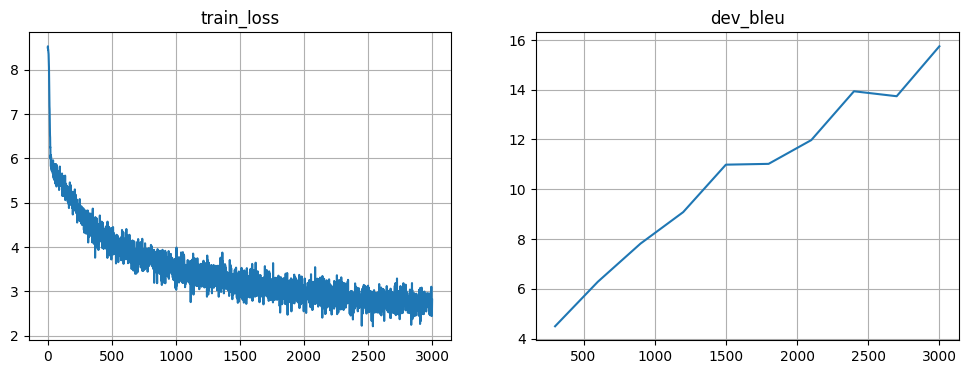

100%|██████████| 3000/3000 [04:41<00:00, 10.65it/s]

Step=3000 | loss=2.692 | BLEU=15.75
Final BLEU (dot-product): 15.594284537785526


In [ ]:
dot_model = AttentiveModelDot(inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128)

dot_model, hist_dot = train_loop(
    dot_model, train_inp, train_out, dev_inp, dev_out,
    n_steps=3000, batch_size=64, eval_every=300, lr=1e-3
)

print("Final BLEU (dot-product):", compute_bleu(dot_model, dev_inp[:1000], dev_out[:1000], max_len=60))

In [ ]:
sample_inp = dev_inp[::500][:5]

translations, _, attention_probs = dot_model.translate_lines(sample_inp, max_len=60)

for i in range(len(sample_inp)):
    print("RU:", sample_inp[i])
    print("EN:", translations[i])
    print()

    # attention_probs: [batch, T_gen, T_inp]
    draw_attention(sample_inp[i], translations[i], attention_probs[i])

RU: в распоряжении гостей общая кухня и общая гостиная .
EN: there is a shared kitchen and a shared kitchen at the property .



RU: кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
EN: the property offers free parking , free parking and free parking .



RU: расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
EN: the city of the city centre is 6 km away .



RU: апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
EN: located in the centre of the apartment , this apartment features a garden , a terrace and a garden with a terrace .



RU: апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
EN: located in the centre of the apartment , 200 metres from the apartment .



###  Сравнение моделей: BLEU, кривые обучения и attention-карты

Теперь делаем три типа сравнения:

1. **Быстрое сравнение BLEU** на подмножестве dev - чтобы не ждать долго и получить ориентир кто лучше прямо сейчас.
2. **Сравнение кривых** `train_loss` и `dev_bleu` на одном графике - полезно видеть не только финальную точку, но и динамику: где обучение стабильнее, где быстрее растёт BLEU, где переобучение.
3. **Сравнение attention-карт на одном примере** - это качественная проверка: модели могут иметь близкий BLEU, но вести себя по-разному (например, одна даёт более локальное внимание, другая - более размазанное).


In [ ]:
dev_subset = 1000  # чтобы не ждать долго на семинаре

bleu_base = compute_bleu(baseline, dev_inp[:dev_subset], dev_out[:dev_subset], max_len=60)
bleu_add  = compute_bleu(attn_model, dev_inp[:dev_subset], dev_out[:dev_subset], max_len=60)
bleu_dot  = compute_bleu(dot_model, dev_inp[:dev_subset], dev_out[:dev_subset], max_len=60)

print(f"BLEU baseline (no attn): {bleu_base:.2f}")
print(f"BLEU additive attn:      {bleu_add:.2f}")
print(f"BLEU dot-product attn:   {bleu_dot:.2f}")

BLEU baseline (no attn): 13.96
BLEU additive attn:      15.03
BLEU dot-product attn:   15.59


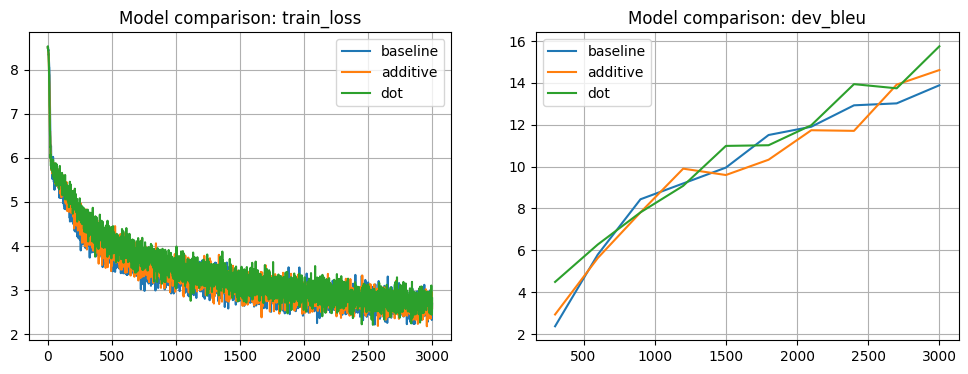

In [ ]:
import matplotlib.pyplot as plt

def plot_history(histories, title_prefix=""):
    """
    histories: список кортежей (name, hist_dict)
    """
    plt.figure(figsize=(12, 4))

    # train_loss
    plt.subplot(1, 2, 1)
    plt.title(f"{title_prefix} train_loss")
    for name, hist in histories:
        xs, ys = zip(*hist["train_loss"])
        plt.plot(xs, ys, label=name)
    plt.grid()
    plt.legend()

    # dev_bleu
    plt.subplot(1, 2, 2)
    plt.title(f"{title_prefix} dev_bleu")
    for name, hist in histories:
        if len(hist["dev_bleu"]) > 0:
            xs, ys = zip(*hist["dev_bleu"])
            plt.plot(xs, ys, label=name)
    plt.grid()
    plt.legend()

    plt.show()

plot_history([
    ("baseline", hist_base),
    ("additive", hist_attn),
    ("dot", hist_dot),
], title_prefix="Model comparison:")

In [ ]:
# сравнение attention-карт на одном и том же примере

idx = 0  # можно менять: 0..len(dev_inp)-1
inp_line = dev_inp[idx]

# сгенерируем перевод и attention_probs для обеих моделей
add_trans, _, add_probs = attn_model.translate_lines([inp_line], max_len=60)
dot_trans, _, dot_probs = dot_model.translate_lines([inp_line], max_len=60)

print("RU:", inp_line)
print("ADD:", add_trans[0])
print("DOT:", dot_trans[0])

print("\nAdditive attention map:")
draw_attention(inp_line, add_trans[0], add_probs[0]) # [T_gen, T_inp]

print("\nDot-product attention map:")
draw_attention(inp_line, dot_trans[0], dot_probs[0]) # [T_gen, T_inp]

RU: в распоряжении гостей общая кухня и общая гостиная .
ADD: there is a shared kitchen and a shared kitchen at the property .
DOT: there is a shared kitchen and a shared kitchen at the property .

Additive attention map:



Dot-product attention map:


### Выводы или как читать результаты

**Baseline** почти всегда проигрывает attention-моделям на длинных зависимостях: ему тяжело держать всю фразу в одном стартовом состоянии.

**Additive attention** обычно даёт наиболее учебно-понятные карты и стабильное качество.

**Dot-product attention** концептуально ближе к трансформерам и иногда проще вычислительно, но сильнее зависит от масштаба (`attn_size`) и общей стабильности обучения.